In [88]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [89]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
sales.describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
3%,0.000000e+00,4.000000e+00,1.307000e+03,7.900000e+01,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
97%,3.200000e+01,5.800000e+01,2.144000e+04,3.190000e+03,3.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


# Aggregate data

In [4]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols).agg({'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index()

#fix column names
gb.rename(index=str,columns={'item_cnt_day': 'item_cnt_month'},inplace=True)

#join aggregated data to the grid
monthly_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

#sort the data
monthly_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [5]:
monthly_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,221.0


In [6]:
monthly_data.describe(percentiles=[0.03, 0.97])

,shop_id,item_id,date_block_num,item_cnt_month,item_price
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,3.118720e+01,1.130926e+04,1.497334e+01,3.342731e-01,1.166070e+02
std,1.734959e+01,6.209978e+03,9.495618e+00,3.417243e+00,6.584686e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
3%,3.000000e+00,9.870000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00,0.000000e+00
97%,5.800000e+01,2.154300e+04,3.200000e+01,2.000000e+00,9.990000e+02
max,5.900000e+01,2.216900e+04,3.300000e+01,2.253000e+03,3.079800e+05


# Combine train and test for lag features

In [7]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test_date_block = monthly_data.date_block_num.max() + 1
test["date_block_num"] = test_date_block
monthly_data["ID"] = -1
all_data = monthly_data.append(test)
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,ID
139255,0,19,0,0.0,0.0,-1
141495,0,27,0,0.0,0.0,-1
144968,0,28,0,0.0,0.0,-1
142661,0,29,0,0.0,0.0,-1
138947,0,32,0,6.0,221.0,-1


# Remove outliers

In [8]:
def clip_by_value(x, min_val, max_val):
    return min(max(min_val, x), max_val)

In [9]:
all_data["item_cnt_month"] = all_data["item_cnt_month"].map(lambda x: clip_by_value(x, 0, 20))
all_data["item_price"] = all_data["item_price"].map(lambda x: clip_by_value(x, 0, 10000))

# Add lag features

In [10]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
cols_to_rename = ["item_cnt_month", "item_price"]

shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12]
min_date_block = 12

lag_features = []

for month_shift in shift_range:
    all_data_shift = all_data[index_cols + cols_to_rename].copy()
    
    all_data_shift['date_block_num'] = all_data_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    all_data_shift = all_data_shift.rename(columns=foo)

    lag_features += ['{}_lag_{}'.format(x, month_shift) for x in cols_to_rename]
    all_data = pd.merge(all_data, all_data_shift, on=index_cols, how='left').fillna(0)

del all_data_shift


In [11]:
print(lag_features)

['item_cnt_month_lag_1', 'item_price_lag_1', 'item_cnt_month_lag_2', 'item_price_lag_2', 'item_cnt_month_lag_3', 'item_price_lag_3', 'item_cnt_month_lag_4', 'item_price_lag_4', 'item_cnt_month_lag_5', 'item_price_lag_5', 'item_cnt_month_lag_6', 'item_price_lag_6', 'item_cnt_month_lag_7', 'item_price_lag_7', 'item_cnt_month_lag_8', 'item_price_lag_8', 'item_cnt_month_lag_9', 'item_price_lag_9', 'item_cnt_month_lag_10', 'item_price_lag_10', 'item_cnt_month_lag_11', 'item_price_lag_11', 'item_cnt_month_lag_12', 'item_price_lag_12']


# Split train and test data

In [12]:
train = all_data[all_data.date_block_num < test_date_block].copy()
del train["ID"]
test = all_data[all_data.date_block_num == test_date_block].copy()

In [13]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_cnt_month_lag_1,item_price_lag_1,item_cnt_month_lag_2,item_price_lag_2,item_cnt_month_lag_3,...,item_cnt_month_lag_8,item_price_lag_8,item_cnt_month_lag_9,item_price_lag_9,item_cnt_month_lag_10,item_price_lag_10,item_cnt_month_lag_11,item_price_lag_11,item_cnt_month_lag_12,item_price_lag_12
0,0,19,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,27,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,32,0,6.0,221.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Add mean encoding

In [14]:
train = pd.merge(train, items[["item_id", "item_category_id"]], on=["item_id"], how="left")
test = pd.merge(test, items[["item_id", "item_category_id"]], on=["item_id"], how="left" )
train["shop_item_id"] = train["shop_id"].astype(str) + "-" + train["item_id"].astype(str)
test["shop_item_id"] = test["shop_id"].astype(str) + "-" + test["item_id"].astype(str)

In [15]:
target = "item_cnt_month"
alpha1 = 100
alpha2 = 10

target_mean = train[target].mean()
item_target_mean = train.groupby("item_id")[target].transform("mean")
item_target_count = train.groupby("item_id")[target].transform("count")
train["item_target_enc"] = (item_target_mean * item_target_count + target_mean * alpha1) / (item_target_count + alpha1)
train["item_target_enc"].fillna(target_mean, inplace=True)

shop_target_mean = train.groupby("shop_id")[target].transform("mean")
shop_target_count = train.groupby("shop_id")[target].transform("count")
train["shop_target_enc"] = (shop_target_mean * shop_target_count + target_mean * alpha1) / (shop_target_count + alpha1)
train["shop_target_enc"].fillna(target_mean, inplace=True)

cate_target_mean = train.groupby("item_category_id")[target].transform("mean")
cate_target_count = train.groupby("item_category_id")[target].transform("count")
train["cate_target_enc"] = (cate_target_mean * cate_target_count + target_mean * alpha1) / (cate_target_count + alpha1)
train["cate_target_enc"].fillna(target_mean, inplace=True)

shop_item_target_mean = train.groupby("shop_item_id")[target].transform("mean")
shop_item_target_count = train.groupby("shop_item_id")[target].transform("count")
train["shop_item_target_enc"] = (shop_item_target_mean * shop_item_target_count + target_mean * alpha2) / (shop_item_target_count + alpha2)
train["shop_item_target_enc"].fillna(target_mean, inplace=True)


In [16]:
item_target_enc_map = train.groupby("item_id")["item_target_enc"].first()
shop_target_enc_map = train.groupby("shop_id")["shop_target_enc"].first()
cate_target_enc_map = train.groupby("item_category_id")["cate_target_enc"].first()
shop_item_target_enc_map = train.groupby("shop_item_id")["shop_item_target_enc"].first()

test["item_target_enc"] = test["item_id"].map(item_target_enc_map)
test["item_target_enc"].fillna(target_mean, inplace=True)

test["shop_target_enc"] = test["shop_id"].map(shop_target_enc_map)
test["shop_target_enc"].fillna(target_mean, inplace=True)

test["cate_target_enc"] = test["item_category_id"].map(cate_target_enc_map)
test["cate_target_enc"].fillna(target_mean, inplace=True)

test["shop_item_target_enc"] = test["shop_item_id"].map(shop_item_target_enc_map)
test["shop_item_target_enc"].fillna(target_mean, inplace=True)

enc_features = ['item_target_enc', 'shop_target_enc', 'cate_target_enc', 'shop_item_target_enc']

# Train/Validation split

In [17]:
valid_date_block  = test_date_block - 1
valid = train[train.date_block_num==valid_date_block].copy()
train = train[train.date_block_num < valid_date_block]
train = train[train.date_block_num >= min_date_block]

In [18]:
train.shape, test.shape

((6186922, 35), (214200, 36))

In [19]:
features = lag_features + enc_features


# Wavenet

In [21]:
train[lag_features].reshape()

,item_cnt_month_lag_1,item_price_lag_1,item_cnt_month_lag_2,item_price_lag_2,item_cnt_month_lag_3,item_price_lag_3,item_cnt_month_lag_4,item_price_lag_4,item_cnt_month_lag_5,item_price_lag_5,...,item_cnt_month_lag_8,item_price_lag_8,item_cnt_month_lag_9,item_price_lag_9,item_cnt_month_lag_10,item_price_lag_10,item_cnt_month_lag_11,item_price_lag_11,item_cnt_month_lag_12,item_price_lag_12
4488756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2499.0
4488757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,359.0,0.0,0.0,0.0,0.0
4488758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,699.0,1.0,698.5,4.0,699.0,0.0,0.0
4488759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,1.0,199.0,2.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10675673,1.0,349.0,0.0,0.0,0.0,0.0,1.0,349.0,1.0,349.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10675674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10675675,0.0,0.0,1.0,699.0,0.0,0.0,0.0,0.0,2.0,699.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10675676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
t = train[lag_features].values.reshape((-1, 12,2))

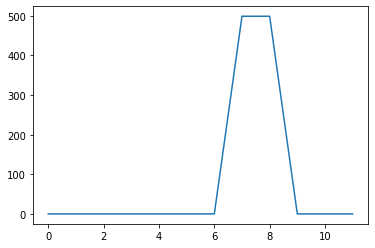

In [49]:
plt.plot(t[1001, :, 1])

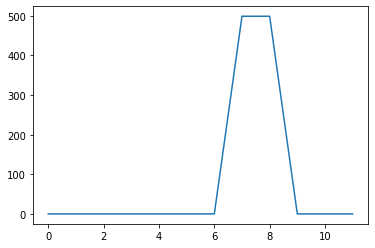

In [48]:
c = ["item_price_lag_%s"%(m+1) for m in range(12)]
train.head(1)[c]
plt.plot(train.iloc[1001][c].values.reshape((-1,)))

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_valid_scaled = scaler.transform(valid[features])
X_test_scaled = scaler.transform(test[features])
Y_train = train[target]
Y_valid = valid[target]

In [69]:
from sklearn.metrics import mean_squared_error

lag_indices = [idx for idx in range(len(features)) if features[idx] in lag_features]
enc_indices = [idx for idx in range(len(features)) if features[idx] in enc_features]
X_train_lag = X_train_scaled[:, lag_indices].reshape((-1, 12, 2))
X_valid_lag = X_valid_scaled[:, lag_indices].reshape((-1, 12, 2))
X_test_lag = X_test_scaled[:, lag_indices].reshape((-1, 12, 2))
X_train_enc = X_train_scaled[:, enc_indices]
X_valid_enc = X_valid_scaled[:, enc_indices]
X_test_enc = X_test_scaled[:, enc_indices]
enc_indices

[24, 25, 26, 27]

In [84]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.metrics import RootMeanSquaredError
np.random.seed(42)
tf.random.set_seed(42)

lag_inputs= layers.Input(shape=(12, 2), name="lag_features")
enc_inputs = layers.Input(shape=(4,), name="enc_features")
x = lag_inputs
for rate in (1, 2, 4, 8) * 2:
    x = layers.Conv1D(filters=20, 
                      kernel_size=2, 
                      padding="causal",
                      activation="relu", 
                      dilation_rate=rate)(x)
x = layers.Conv1D(20, kernel_size=1)(x)
x = layers.Flatten()(x)
concat = layers.concatenate([x, enc_inputs],axis=-1)
concat = layers.Dense(10, activation='relu')(concat)
output = layers.Dense(1, activation='linear')(concat)
model = models.Model([lag_inputs,enc_inputs],output)
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lag_features (InputLayer)       [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 12, 20)       100         lag_features[0][0]               
__________________________________________________________________________________________________
conv1d_142 (Conv1D)             (None, 12, 20)       820         conv1d_141[0][0]                 
__________________________________________________________________________________________________
conv1d_143 (Conv1D)             (None, 12, 20)       820         conv1d_142[0][0]                 
____________________________________________________________________________________________

In [85]:
early_stopping_cb = callbacks.EarlyStopping(patience=3)

model_checkpoint_cb = callbacks.ModelCheckpoint("./", monitor='val_loss', 
                                                verbose=0, 
                                                save_best_only=False,
                                                save_weights_only=False, 
                                                mode='auto', 
                                                save_freq='epoch')

tensorboard_cb = callbacks.TensorBoard(log_dir='logs', 
                                       histogram_freq=0, 
                                       write_graph=True,
                                       write_images=False, 
                                       update_freq='epoch')
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit([X_train_lag, X_train_enc], Y_train, epochs=10,
                     validation_data=([X_valid_lag, X_valid_enc], Y_valid),
                   callbacks=callbacks)

Epoch 1/10
193342/193342 [==============================] - 528s 3ms/step - loss: 0.6153 - root_mean_squared_error: 0.7840 - val_loss: 0.6070 - val_root_mean_squared_error: 0.7791
INFO:tensorflow:Assets written to: ./assets
Epoch 2/10
193342/193342 [==============================] - 521s 3ms/step - loss: 0.5833 - root_mean_squared_error: 0.7637 - val_loss: 0.6003 - val_root_mean_squared_error: 0.7748
INFO:tensorflow:Assets written to: ./assets
Epoch 3/10
193342/193342 [==============================] - 566s 3ms/step - loss: 0.5702 - root_mean_squared_error: 0.7551 - val_loss: 0.5955 - val_root_mean_squared_error: 0.7717
INFO:tensorflow:Assets written to: ./assets
Epoch 4/10
193342/193342 [==============================] - 492s 3ms/step - loss: 0.5718 - root_mean_squared_error: 0.7562 - val_loss: 0.6144 - val_root_mean_squared_error: 0.7838
INFO:tensorflow:Assets written to: ./assets
Epoch 5/10
193342/193342 [==============================] - 555s 3ms/step - loss: 0.5709 - root_mean_squ

In [87]:
test["item_cnt_month"] = model.predict([X_test_lag, X_test_enc])
test["item_cnt_month"].fillna(0, inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].map(lambda x: min(max(0, x), 20))
test[["ID", "item_cnt_month"]].to_csv("submission_cnn.csv", index=False)